# Imports

In [22]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

import html
from bs4 import BeautifulSoup
import requests
from requests.exceptions import Timeout
import pandas as pd
import numpy as np
import cupy as cp
from helium import * # if helium gives you chrome webdriver error, download latest chrome driver, and move it to here: .conda\Lib\site-packages\helium\_impl\webdrivers\windows ... source: https://github.com/mherrmann/selenium-python-helium/issues/55
import cv2
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver import ChromeOptions

import string
import logging
from pprint import pprint
import regex as re
from multiprocessing import Process
import pickle
import os
import glob
import base64
from sys import getsizeof
import shutil
import json
import time
from datetime import datetime

from IPython.display import display, HTML
import ipywidgets
import heapq
import matplotlib.pyplot  as plt
from PIL import Image, ImageFile, ImageOps, ImageDraw
from PIL.ExifTags import TAGS
from pathlib import Path
import imagesize
import imghdr
import exifread
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path as mplPath
import image_to_numpy
import pytesseract

import cufflinks as cf
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from plotly.offline import init_notebook_mode

from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output

import unicodedata2
import lzma
from tqdm.notebook import tqdm
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed, wait
from functools import partial

from tensorflow import keras
from keras import optimizers, datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import backend as K
import tensorflow_addons as tfa
from sklearn.metrics import classification_report 

# import easyocr
from retinaface import RetinaFace
from paddleocr import PaddleOCR, draw_ocr

import wordsegment
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import qalsadi.lemmatizer

# import download_imgs # used in getAsyncImgFunctions()

In [10]:
def pklSave(contentToBeSaved, fullPath):
    with open(fullPath, 'wb') as f:
        pickle.dump(contentToBeSaved, f)

def pklLoad(fullPath):
    with open(fullPath, 'rb') as f:
        content = pickle.load(f)
    return content

def pklForceLoad(path, dtype = 'dict'):
    try:
        content = pklLoad(path)
        return content
    except Exception as e:
        if dtype == 'list':
            pklSave([], path)
            return []
        else:
            pklSave({}, path)
            return {}

# more about naming standards for path components here: https://stackoverflow.com/questions/2235173/what-is-the-naming-standard-for-path-components
def joinPaths(baseDirectory, relativePath):
    return os.path.normpath(os.path.join(baseDirectory, relativePath))

def changeSep(path, newSep, oldSep=os.path.sep): 
    # source: https://stackoverflow.com/questions/18707338/print-raw-string-from-variable-not-getting-the-answers#:~:text=To%20turn%20a%20variable%20to%20raw%20str%2C%20just%20use
    return os.path.normpath(rf"{path}").replace(os.path.sep, newSep) # source: https://mail.python.org/pipermail/tutor/2011-July/084788.html

def pillowOpenOriented(path):
    img = Image.open(path)
    exif_data = img.getexif()
    if 274 in exif_data.keys():
        img = ImageOps.exif_transpose(img)
    return img

# Separating Screenshots From Photos Using get_highest_color_counts()

In [11]:
def combine_color_channels(R, G, B):
    return (R << 16) + (G << 8) + B

# draft (currently not used):
def extract_color_channels(color):
    R = (color >> 16) & 0xFF
    G = (color >> 8) & 0xFF
    B = color & 0xFF
    return (R, G, B)

def get_highest_color_counts(img, top_n=3):
    """
    Get a list of (count, color) tuples for each pixel color in the image

    Return Values' Notes:
    [(color_from_rgb_to_24_bits, highest_count), ..., ..., until top_n_frequent_colors]
    """
    
    # unique_colors = cupy_unique_axis0(img)
    # print(unique_colors[0])
    
    # to do: remove this code if you found gpu alternative
    try:
        unique_colors = img.getcolors(10000000) # Should never give overflow error if we didn't increase than 10000000, but just in case :]
        if unique_colors is None:
            img = img.resize((1000-1, 1000-1))
            unique_colors = img.getcolors(10000000)
    except OverflowError as e:
        unique_colors = img.getcolors(1000000)
    except MemoryError as e:
        print("Memory is full... returning (-1,0)")
        return (-1, 0)
    
    w, h = img.size

    # Find the top n colors with the highest count
    # Note that heapq.nlargest() is more efficient than: 
    # sorted(color_counts.items(), key=lambda x: x[1], reverse=True)[:top_n_frequent_colors]
    top_colors = heapq.nlargest(top_n, unique_colors, key=lambda x: x[0])
    
    top_n_color_and_color_to_image_ratio = []
    for count, color in top_colors:
        if isinstance(color, int) and color == 0:
            color = (0, 0, 0)
        r, g, b = color # # ignore the following comment (draft) --> ", *_" is used as sometimes Image.getcolors() returns 4 channels, the fourth representing alpha
        top_n_color = combine_color_channels(r,g,b)
        color_to_image_ratio = round(count/(w*h), 5)
        top_n_color_and_color_to_image_ratio.append((top_n_color, color_to_image_ratio))
    
    # Return the top N colors with their counts
    return top_n_color_and_color_to_image_ratio


In [51]:
# draft, debugging: seeing a good threshold to split screenshots from photos taken by a camera (this and next cell)
path_to_folder = '../dataset/20. ememes/'
max_color_counts = []
# Create a dictionary to store the images
image_dict = {}

for filename in os.listdir(path_to_folder):
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        # Open the image file
        img_path = os.path.join(path_to_folder, filename)
        img = Image.open(img_path) 
        img = img.convert('RGB')
        # img = img.resize((306,306))

        # Calculate the max color count and add it to the list
        print(filename)
        max_color_count = get_highest_color_counts(img, top_n=1)

        # Add the image to the dictionary with its max pixel value
        image_dict[filename] = {'max_color_count': max_color_count[0][1], 'image': img_path}
        # img.close()

ememes0000000.jpg
ememes0000001.jpg
ememes0000002.jpg
ememes0000003.jpg
ememes0000004.jpg
ememes0000005.jpg
ememes0000006.jpg
ememes0000007.jpg
ememes0000008.jpg
ememes0000009.jpg
ememes0000010.jpg
ememes0000011.jpg
ememes0000012.jpg
ememes0000013.jpg
ememes0000014.jpg
ememes0000015.jpg
ememes0000016.jpg
ememes0000017.jpg
ememes0000018.jpg
ememes0000019.jpg
ememes0000020.jpg
ememes0000021.jpg
ememes0000022.jpg
ememes0000023.jpg
ememes0000024.jpg
ememes0000025.jpg
ememes0000026.jpg
ememes0000027.jpg
ememes0000028.jpg
ememes0000029.jpg
ememes0000030.jpg
ememes0000031.jpg
ememes0000032.jpg
ememes0000033.jpg
ememes0000034.jpg
ememes0000035.jpg
ememes0000036.jpg
ememes0000037.jpg
ememes0000038.jpg
ememes0000039.jpg
ememes0000040.jpg
ememes0000041.jpg
ememes0000042.jpg
ememes0000043.jpg
ememes0000044.jpg
ememes0000045.jpg
ememes0000046.jpg
ememes0000047.jpg
ememes0000048.jpg
ememes0000049.jpg
ememes0000050.jpg
ememes0000051.jpg
ememes0000052.jpg
ememes0000053.jpg
ememes0000054.jpg
ememes0000

In [ ]:
# Sort the list of tuples by the second value (max pixel value) in descending order
image_list = sorted(image_dict.items(), key=lambda x: x[1]['max_color_count'], reverse=True)

In [ ]:
image_list

[('ememes0003606.jpg',
  {'max_color_count': 0.97383,
   'image': '../dataset/20. ememes/ememes0003606.jpg'}),
 ('ememes0003607.jpg',
  {'max_color_count': 0.97272,
   'image': '../dataset/20. ememes/ememes0003607.jpg'}),
 ('ememes0003103.jpg',
  {'max_color_count': 0.95581,
   'image': '../dataset/20. ememes/ememes0003103.jpg'}),
 ('ememes0005787.jpg',
  {'max_color_count': 0.95077,
   'image': '../dataset/20. ememes/ememes0005787.jpg'}),
 ('ememes0010209.jpg',
  {'max_color_count': 0.94675,
   'image': '../dataset/20. ememes/ememes0010209.jpg'}),
 ('ememes0008206.jpg',
  {'max_color_count': 0.94666,
   'image': '../dataset/20. ememes/ememes0008206.jpg'}),
 ('ememes0006103.jpg',
  {'max_color_count': 0.93682,
   'image': '../dataset/20. ememes/ememes0006103.jpg'}),
 ('ememes0006389.jpg',
  {'max_color_count': 0.93582,
   'image': '../dataset/20. ememes/ememes0006389.jpg'}),
 ('ememes0005612.jpg',
  {'max_color_count': 0.93555,
   'image': '../dataset/20. ememes/ememes0005612.jpg'}),
 

In [ ]:
len(image_list)

13667

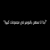

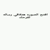

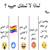

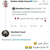

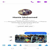

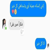

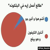

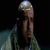

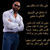

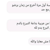

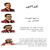

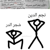

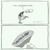

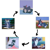

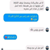

In [ ]:
# Create a hover widget that displays the image preview
def on_hover(change):
    filename = change['new']
    if filename in [f'{i}_{filename_and_dict[0]}' for i, filename_and_dict in enumerate(image_list)]:
        image = Image.open(image_dict[filename[filename.find('_')+1:]]['image'])
        display(image.resize((50,50)))

# Create a list widget that displays the filenames
list_widget = ipywidgets.Select(
    options= [f'{i}_{filename_and_dict[0]}' for i, filename_and_dict in enumerate(image_list)],
    description='Filenames:',
    layout=ipywidgets.Layout(width='50%')
)

# Link the hover widget to the list widget
list_widget.observe(on_hover, names='value')

# Create a VBox container for the widgets
container = ipywidgets.VBox([list_widget])

# Display the container
display(container)

In [17]:
# debugging:
# by manually checking the image's displays, we see that most of the images until index 936 are screenshots, so we'll move these images
for i, filename in enumerate([filename_and_dict[0] for filename_and_dict in image_list]):
    if i == 3:
        break
    src_path = joinPaths('../dataset/20. ememes/', filename)
    dest_path = joinPaths('../dataset/20. ememes/', f'{i}_{filename}')
    shutil.move(src_path, dest_path)

# Separating Text Messages, ESocialMediaPosts, And EMemes Using Text Properties

In [23]:
ImageFile.LOAD_TRUNCATED_IMAGES = True # to load very large images instead of getting an "image file is truncated" error
paddle_ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=True) # need to run only once to download and load model into memory
paddle_ocr = PaddleOCR(use_angle_cls=True, lang='ar', use_gpu=True) # need to run only once to download and load model into memory
paddle_ocr = PaddleOCR(use_angle_cls=True, use_gpu=True, lang="ar", text_recognizer_cfg= {
                            'TextBoxBuilder': {
                                # 'min_size': 16,
                                'score_thresh': 0.8,
                                # 'nms_thresh': 0.2
                            }
                       }) # need to run only once to download and load model into memory
logging.getLogger('ppocr').setLevel(logging.WARNING) # to disable ppocr debug messages at each image input (e.g., [2023/03/14 06:41:22] ppocr DEBUG: dt_boxes num : 0, elapse : 0.014979839324951172)
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf.config.list_physical_devices('GPU')

[2023/03/18 17:15:06] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ashra/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ashra/.paddleocr/whl\\rec\\en\\en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [38]:
def get_text_boxes_num(img):
    try:
        return len(paddle_ocr.ocr(np.array(img), det=True, rec=False, cls=True)[0])
    except:
        return 0

In [45]:
# draft, debugging: seeing a good threshold to split screenshots from photos taken by a camera (this and next cell)
path_to_folder = '../dataset/20. ememes/'
max_color_counts = []
# Create a dictionary to store the images
image_dict_2 = {}

for filename in os.listdir(path_to_folder):
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        # Open the image file
        img_path = os.path.join(path_to_folder, filename)
        img = Image.open(img_path) 
        img = img.convert('RGB')
        # img = img.resize((306,306))

        # Calculate the max color count and add it to the list
        print(filename)
        text_boxes_num = get_text_boxes_num(img)

        # Add the image to the dictionary with its max pixel value
        image_dict_2[filename] = {'text_boxes_num': text_boxes_num, 'image': img_path}
        # img.close()

ememes0000000.jpg
ememes0000001.jpg
ememes0000002.jpg
ememes0000003.jpg
ememes0000004.jpg
ememes0000005.jpg
ememes0000006.jpg
ememes0000007.jpg
ememes0000008.jpg
ememes0000009.jpg
ememes0000010.jpg
ememes0000011.jpg
ememes0000012.jpg
ememes0000013.jpg
ememes0000014.jpg
ememes0000015.jpg
ememes0000016.jpg
ememes0000017.jpg
ememes0000018.jpg
ememes0000019.jpg
ememes0000020.jpg
ememes0000021.jpg
ememes0000022.jpg
ememes0000023.jpg
ememes0000024.jpg
ememes0000025.jpg
ememes0000026.jpg
ememes0000027.jpg
ememes0000028.jpg
ememes0000029.jpg
ememes0000030.jpg
ememes0000031.jpg
ememes0000032.jpg
ememes0000033.jpg
ememes0000034.jpg
ememes0000035.jpg
ememes0000036.jpg
ememes0000037.jpg
ememes0000038.jpg
ememes0000039.jpg
ememes0000040.jpg
ememes0000041.jpg
ememes0000042.jpg
ememes0000043.jpg
ememes0000044.jpg
ememes0000045.jpg
ememes0000046.jpg
ememes0000047.jpg
ememes0000048.jpg
ememes0000049.jpg
ememes0000050.jpg
ememes0000051.jpg
ememes0000052.jpg
ememes0000053.jpg
ememes0000054.jpg
ememes0000

In [46]:
# Sort the list of tuples by the second value (max pixel value) in descending order
image_list_2 = sorted(image_dict_2.items(), key=lambda x: x[1]['text_boxes_num'], reverse=True)

In [47]:
image_list_2

[('ememes0011424.jpg',
  {'text_boxes_num': 223, 'image': '../dataset/20. ememes/ememes0011424.jpg'}),
 ('ememes0002273.jpg',
  {'text_boxes_num': 175, 'image': '../dataset/20. ememes/ememes0002273.jpg'}),
 ('ememes0005061.jpg',
  {'text_boxes_num': 172, 'image': '../dataset/20. ememes/ememes0005061.jpg'}),
 ('ememes0010977.jpg',
  {'text_boxes_num': 155, 'image': '../dataset/20. ememes/ememes0010977.jpg'}),
 ('ememes0009784.jpg',
  {'text_boxes_num': 127, 'image': '../dataset/20. ememes/ememes0009784.jpg'}),
 ('ememes0009415.jpg',
  {'text_boxes_num': 120, 'image': '../dataset/20. ememes/ememes0009415.jpg'}),
 ('ememes0009925.jpg',
  {'text_boxes_num': 120, 'image': '../dataset/20. ememes/ememes0009925.jpg'}),
 ('ememes0012109.jpg',
  {'text_boxes_num': 119, 'image': '../dataset/20. ememes/ememes0012109.jpg'}),
 ('ememes0009543.jpg',
  {'text_boxes_num': 114, 'image': '../dataset/20. ememes/ememes0009543.jpg'}),
 ('ememes0001762.jpg',
  {'text_boxes_num': 112, 'image': '../dataset/20.

In [48]:
len(image_list_2)

13670

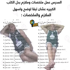

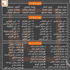

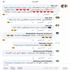

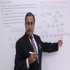

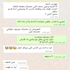

In [49]:
# Create a hover widget that displays the image preview
def on_hover(change):
    filename = change['new']
    if filename in [f'{i}_{filename_and_dict[0]}' for i, filename_and_dict in enumerate(image_list_2)]:
        image = Image.open(image_dict_2[filename[filename.find('_')+1:]]['image'])
        display(image.resize((70,70)))

# Create a list widget that displays the filenames
list_widget = ipywidgets.Select(
    options= [f'{i}_{filename_and_dict[0]}' for i, filename_and_dict in enumerate(image_list_2)],
    description='Filenames:',
    layout=ipywidgets.Layout(width='50%')
)

# Link the hover widget to the list widget
list_widget.observe(on_hover, names='value')

# Create a VBox container for the widgets
container = ipywidgets.VBox([list_widget])

# Display the container
display(container)

In [50]:
# debugging:
# by manually checking the image's displays, we see that most of the images until index 936 are screenshots, so we'll move these images
for i, filename in enumerate([filename_and_dict[0] for filename_and_dict in image_list_2]):
    if i == -1:
        break
    src_path = joinPaths('../dataset/20. ememes/', filename)
    dest_path = joinPaths('../dataset/20. ememes/', f'{i}_{filename}')
    shutil.move(src_path, dest_path)